# Analyses of the paper

This notebook is doing the DNA figures found in Supplementary of the paper.

First testing if the installation is correct.

In [65]:
%%bash 

if [[ -z "$PROTNAFF" ]]; then
    echo "You did not do the installation correctly, please refer to the INSTALLATION.md"
else
    cmd="x3dna-dssr"
    if [[ $(type -P "$cmd") ]]; then
        echo "The installation seems correct."
    else
        echo "x3dna-dssr is not correctly installed."        
    fi
fi

The installation seems correct.


In [66]:
!mkdir -p $PROTNAFF/data_dna
!cd $PROTNAFF/data_dna && bash $PROTNAFF/create_database.sh $PROTNAFF/id_dna.list dna

---------------------------- Download PDBs
-------------------------- check pdb
-------------------------- detect NA - protein interface 
---------------------------------  parse initial pdb
--------------------------------- Fill-up missing atoms 
-------------------------------- apply 3dna
Done


In [67]:
!cd $PROTNAFF/data_dna && bash $PROTNAFF/create_frag_library.sh dna

create_template
-------------------------------- fragments clustering
create PDB fragments (for mutating) from clust1.0, CCC
Convert CCC library into coarse-grained
185
create PDB fragments (for mutating) from clust1.0, CCA
Convert CCA library into coarse-grained
215
create PDB fragments (for mutating) from clust1.0, CAC
Convert CAC library into coarse-grained
352
create PDB fragments (for mutating) from clust1.0, CAA
Convert CAA library into coarse-grained
246
create PDB fragments (for mutating) from clust1.0, ACC
Convert ACC library into coarse-grained
202
create PDB fragments (for mutating) from clust1.0, ACA
Convert ACA library into coarse-grained
357
create PDB fragments (for mutating) from clust1.0, AAC
Convert AAC library into coarse-grained
232
create PDB fragments (for mutating) from clust1.0, AAA
Convert AAA library into coarse-grained
259
CCC
CCC-aa-fit-clust0.2
CCC-dr0.2r-clust1.0
CCC-dr0.2r-clust1.0-clust3.0
CCA
CCA-aa-fit-clust0.2
CCA-dr0.2r-clust1.0
CCA-dr0.2r-clust1.0-c

In [68]:
import os
import json
import numpy as np

#The packages for statistics
import scipy.stats
from statsmodels.stats.proportion import proportions_ztest

#The graphics libraries
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

folder = "./data_dna"

if not os.path.isfile("{}/structures.json".format(folder)) or not os.path.isfile("{}/fragments.json".format(folder)):
    print("You need to run the data_protnaff.ipynb first.")
else:
    print("You can continue.")

You can continue.


In [69]:
structures = json.load(open("{}/structures.json".format(folder)))
fragments = json.load(open("{}/fragments_clust.json".format(folder)))

## Do NMR structures contain more ssDNA than X-ray structures?

Here are simple statistics, the `structures` is parsed, and for each structure, the experimental method is count as x-ray or nmr.

Then a percentage of each method is made and an exact fisher test is performed to know if the results are different or not.

In [70]:
result = {"x-ray":{"ss":0, "ds":0}, "nmr":{"ss":0, "ds":0}}

x = 0
n = 0

for value in structures.values():
    if value["method"] == "x-ray diffraction":
        x += 1
        for chain in value['ss'].values():
            for res in chain.values():
                if res[0] == "D":
                    result["x-ray"]["ds"] += 1
                else:
                    result["x-ray"]["ss"] += 1
    elif value["method"] == "solution nmr" or value["method"] == "solution nmr; theoretical model" or value["method"] == "solid-state nmr":
        n += 1
        for chain in value['ss'].values():
            for res in chain.values():
                if res[0] == "D":
                    result["nmr"]["ds"] += 1
                else:
                    result["nmr"]["ss"] += 1
print(result)
print("Structures from X-ray: {}, structures from NMR: {}".format(x,n))
x_per = round((result["x-ray"]['ss']*100/(result["x-ray"]['ss'] + result["x-ray"]['ds'])),2)
rmn_per = round((result["nmr"]['ss']*100/(result["nmr"]['ss']+result["nmr"]['ds'])),2)
print("Percentages ss: X-ray: {}%, NMR: {}%".format(x_per, rmn_per))

(oddsratio, pvalue) = scipy.stats.fisher_exact([[result["x-ray"]['ss'], result["nmr"]['ss']], [result["x-ray"]['ds'], result["nmr"]['ds']]])
print("The p-value of the exact fisher test is: {:.3f}".format(pvalue))

{'x-ray': {'ss': 1238, 'ds': 6709}, 'nmr': {'ss': 10, 'ds': 0}}
Structures from X-ray: 299, structures from NMR: 1
Percentages ss: X-ray: 15.58%, NMR: 100.0%
The p-value of the exact fisher test is: 0.000


As their are more nucleotides single-stranded than expected we will investigate a bit more.

In [71]:
structures_rna = json.load(open("{}/structures.json".format("./data_paper")))

In [72]:
structures['1S76']['nachains']

['T', 'N']

In [73]:
somme = 0
stru = 0
for key in structures.keys():
    if structures[key]['method'] == "x-ray diffraction":
        for chain, chain_ss in structures[key]['ss'].items():
            con_ss = 0
            nocon_ss = 0
            con_ds = 0
            nocon_ds = 0
            list_inter_tmp = list(structures[key]['interface_protein']['model_1'][chain].keys())
            for res, value_ss in chain_ss.items():
                if value_ss[0] != "D":
                    if res in list_inter_tmp:
                        con_ss += 1
                    else:
                        nocon_ss += 1
                else:
                    if res in list_inter_tmp:
                        con_ds += 1
                    else:
                        nocon_ds += 1
            if nocon_ss !=0 and nocon_ss / (nocon_ss + nocon_ds) > 0.15:
                print(key, chain, nocon_ss / (nocon_ss + nocon_ds))
            if nocon_ss != 0:
                stru += 1
            somme += nocon_ss
print(stru, somme)

1MSW chain_N 0.42857142857142855
1MSW chain_T 0.25
1S76 chain_N 0.5
1S76 chain_T 0.6666666666666666
1S77 chain_N 0.16666666666666666
2DLC chain_Y 0.35
2HVS chain_H 0.2
2NVQ chain_N 0.3333333333333333
2NVQ chain_T 0.38461538461538464
2QKB chain_D 1.0
3AGV chain_U 0.5333333333333333
3DD2 chain_B 0.18181818181818182
3KJO chain_B 1.0
3KYL chain_E 0.5714285714285714
4BOC chain_N 0.23076923076923078
4KHS chain_T 0.2
4KHU chain_T 0.2
4KHW chain_T 0.2
4KHY chain_T 0.2
4KI4 chain_T 0.2
4KI6 chain_T 0.2
4NDFA chain_E 0.2
4NDFB chain_E 0.2
4NDFB chain_H 0.16666666666666666
4NDG chain_E 0.2
4NDIA chain_E 0.2
4NDIB chain_E 0.2
4UN3 chain_D 0.4
4UN4 chain_D 0.4
4UN5 chain_D 0.6
5BS3 chain_E 0.3333333333333333
5DO4 chain_A 0.2222222222222222
5F0Q chain_F 1.0
5F0S chain_F 1.0
5FQ5 chain_D 0.2
5FW1 chain_D 0.5
5FW2 chain_D 0.4
5FW3 chain_D 0.4
5H9F chain_M 0.3076923076923077
5N9G chain_I 0.2222222222222222
5NFV chain_C 0.16666666666666666
5NFV chain_D 0.42857142857142855
5SWMA chain_C 1.0
5SWMB chain_C

In [74]:
for key in structures.keys():
    if key == '5BS3':
        if structures[key]['method'] == "x-ray diffraction":
            for chain, chain_ss in structures[key]['ss'].items():
                con_ss = 0
                nocon_ss = 0
                con_ds = 0
                nocon_ds = 0
                list_inter_tmp = list(structures[key]['interface_protein']['model_1'][chain].keys())
                for res, value_ss in chain_ss.items():
                    if value_ss[0] != "D":
                        if res in list_inter_tmp:
                            con_ss += 1
                        else:
                            nocon_ss += 1
                            print(res, chain)
                    else:
                        if res in list_inter_tmp:
                            con_ds += 1
                        else:
                            nocon_ds += 1
                if nocon_ss !=0 and nocon_ss / (nocon_ss + nocon_ds) > 0.15:
                    print(key, chain, nocon_ss / (nocon_ss + nocon_ds))

res_1 chain_E
5BS3 chain_E 0.3333333333333333


In [75]:
structures['7EU9']['ss']

{'chain_C': {'res_1': ['S', 1, 31],
  'res_10': ['D', 10, 31],
  'res_11': ['D', 11, 31],
  'res_12': ['D', 12, 31],
  'res_13': ['D', 13, 31],
  'res_14': ['D', 14, 31],
  'res_15': ['D', 15, 31],
  'res_16': ['D', 16, 31],
  'res_17': ['D', 17, 31],
  'res_18': ['D', 18, 31],
  'res_19': ['D', 19, 31],
  'res_2': ['S', 2, 31],
  'res_20': ['D', 20, 31],
  'res_21': ['D', 21, 31],
  'res_22': ['D', 22, 31],
  'res_23': ['D', 23, 31],
  'res_24': ['D', 24, 31],
  'res_25': ['D', 25, 31],
  'res_26': ['D', 26, 31],
  'res_27': ['D', 27, 31],
  'res_28': ['D', 28, 31],
  'res_29': ['D', 29, 31],
  'res_3': ['S', 3, 31],
  'res_30': ['D', 30, 31],
  'res_31': ['D', 31, 31],
  'res_4': ['D', 4, 31],
  'res_5': ['D', 5, 31],
  'res_6': ['D', 6, 31],
  'res_7': ['D', 7, 31],
  'res_8': ['D', 8, 31],
  'res_9': ['D', 9, 31]},
 'chain_D': {'res_1': ['D', 1, 24],
  'res_10': ['S', 10, 24],
  'res_11': ['S', 11, 24],
  'res_12': ['S', 12, 24],
  'res_13': ['S', 13, 24],
  'res_14': ['S', 14, 24]

In [76]:
investigation = {'rna':{'contact':0, 'nocontact':0}, 'dna':{'contact':0, 'nocontact':0}}
for value in structures.values():
    if value['method'] == "x-ray diffraction":
        for chain, chain_ss in value['ss'].items():
            list_inter_tmp = list(value['interface_protein']['model_1'][chain].keys())
            for res, value_ss in chain_ss.items():
                if value_ss[0] == "D":
                    if res in list_inter_tmp:
                        investigation['dna']['contact'] += 1
                    else:
                        investigation['dna']['nocontact'] += 1
for value in structures_rna.values():
    if value['method'] == "x-ray diffraction":
        for chain, chain_ss in value['ss'].items():
            list_inter_tmp = list(value['interface_protein']['model_1'][chain].keys())
            for res, value_ss in chain_ss.items():
                if value_ss[0] == "D":
                    if res in list_inter_tmp:
                        investigation['rna']['contact'] += 1
                    else:
                        investigation['rna']['nocontact'] += 1

In [77]:
print(investigation)
print("Percentage contact DNA: {}%".format(100*investigation["dna"]['contact']/(investigation["dna"]['contact']+investigation["dna"]['nocontact'])))
print("Percentage contact RNA: {}%".format(100*investigation["rna"]['contact']/(investigation["rna"]['contact']+investigation["rna"]['nocontact'])))
(oddsratio, pvalue) = scipy.stats.fisher_exact([[investigation["rna"]['contact'], investigation["rna"]['nocontact']], [investigation["dna"]['contact'], investigation["dna"]['nocontact']]])
print("The p-value of the exact fisher test is: {:.3f}".format(pvalue))

{'rna': {'contact': 11542, 'nocontact': 16466}, 'dna': {'contact': 5211, 'nocontact': 1498}}
Percentage contact DNA: 77.67178417051721%
Percentage contact RNA: 41.20965438446158%
The p-value of the exact fisher test is: 0.000


## Conformational diversity of DNA fragments at different scales

The first cell is making the figure showing the number of elements in the clusters at 1A and 3A.

The second cell is showing in details the composition of those clusters, by printing the number of clusters of a given size (number of elements).

The next cell is doing the Figure 2 of the paper (link).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


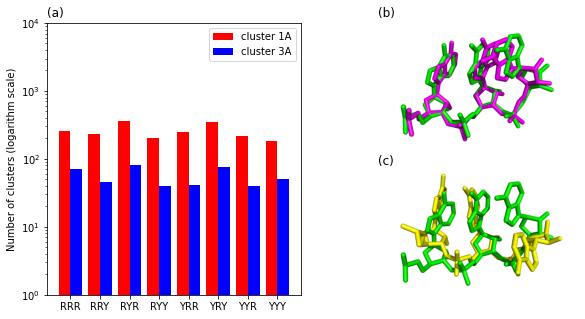

In [102]:
tick = ["RRR", "RRY", "RYR", "RYY", "YRR", "YRY", "YYR", "YYY"]
motifs = ['AAA', 'AAC', 'ACA', 'ACC', 'CAA', 'CAC', 'CCA', 'CCC']
clust_1A = []
clust_3A = []
for motif in motifs:
    with open("{}/trilib/{}-dr0.2r-clust1.0".format(folder, motif)) as ff:
        for n_line_1A, _ in enumerate(ff):
            pass
        clust_1A.append(n_line_1A)
    with open("{}/trilib/{}-dr0.2r-clust1.0-clust3.0".format(folder, motif)) as ff3:
        for n_line_3A, _ in enumerate(ff3):
            pass
        clust_3A.append(n_line_3A)

plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(2, 2)
ax = plt.subplot(gs[:, 0])
ax.set_title('(a)', loc='left')
plt.bar([1, 2, 3, 4, 5, 6, 7, 8], clust_1A, 0.4, label="cluster 1A", log=True, color='red')
plt.bar([1.4, 2.4, 3.4, 4.4, 5.4, 6.4, 7.4, 8.4], clust_3A, 0.4, label="cluster 3A", log=True, color='blue')
plt.ylabel("Number of clusters (logarithm scale)")
plt.xticks([1.2, 2.2, 3.2, 4.2, 5.2, 6.2, 7.2, 8.2], tick)
plt.ylim(1, 10000)
plt.legend()
ax = plt.subplot(gs[0, 1])
ax.set_title('(b)', loc='left')
img = mpimg.imread('./alignement_1A.png')
imgplot = plt.imshow(img)
plt.axis('off')
ax = plt.subplot(gs[1, 1])
ax.set_title('(c)', loc='left')
img = mpimg.imread('./alignement_3A.png')
imgplot = plt.imshow(img)
plt.axis('off')
plt.savefig('fig7.eps', facecolor="w", dpi=600, format='eps')
plt.show()

The next cell is doing the Figure 3 of the paper.

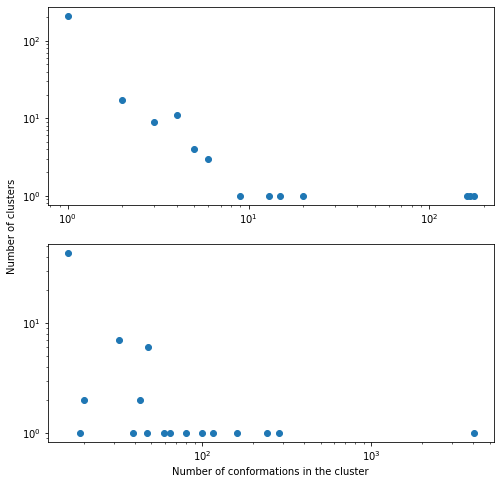

In [101]:
def create_fig3(file_cluster1A, file_cluster3A):
    with open(file_cluster1A) as ff:
        lines1A = ff.readlines()
    res1A = {}
    for line in lines1A:
        line = line.split(' ')
        len_line = len(line) - 4
        if len_line in res1A.keys():
            res1A[len_line] += 1
        else:
            res1A[len_line] = 1
    with open(file_cluster3A) as ff:
        lines3A = ff.readlines()
    res3A = {}
    for line in lines3A:
        line = line.split(' ')
        len_line3A = 0
        for cc in line[4:-1]:
            len_line3A += len(lines1A[int(cc)-1]) -4
        if len_line3A in res3A.keys():
            res3A[len_line3A] += 1
        else:
            res3A[len_line3A] = 1
    return res1A, res3A

res_1A, res_3A = create_fig3("{}/trilib/AAA-dr0.2r-clust1.0".format(folder), \
                             "{}/trilib/AAA-dr0.2r-clust1.0-clust3.0".format(folder))
        
# Then creation of plots
fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(2, 1)
ax1 = plt.subplot(gs[0, 0])
ax1.scatter(res_1A.keys(), res_1A.values())
ax1.set_xscale("log")
ax1.set_yscale("log")
ax2 = plt.subplot(gs[1, 0])
ax2.scatter(res_3A.keys(), res_3A.values())
ax2.set_xscale("log")
ax2.set_yscale("log")

fig.text(0.055, 0.5, "Number of clusters", va='center', rotation='vertical')
plt.xlabel("Number of conformations in the cluster")
plt.savefig("fig8.eps", facecolor="w", bbox_inches='tight', dpi=600, format='eps')
plt.show()

## DNA local conformations induced by protein binding

In this part of the paper, we are interested in the conformations that are induced by the contact with the protein. To understand if the contact with the protein is implying particular conformations, we are parsing the `fragments` dictionnary and extracting the informations about all clusters. The clusters can be fully single-strande, or fully double stranded or a mix of ss and ds conformations. They also can be fully in contact or fully not in contact or a mix between contact and no contact with the protein.

In [80]:
def parsing_fragments(fragments, structures, cutoff):
    """
    This function will parse the fragments dictionnary to extract information about clusters, 
    then it will parse those clusters to extract their properties.
    results are the results for each clusters
    res_bis is a sum of information by clusters
    """
    results = {"AAA":{}, "AAC":{}, "ACA":{}, "ACC":{}, "CAA":{}, "CAC":{}, "CCA":{}, "CCC":{}}
    res_bis = {"AAA":{}, "AAC":{}, "ACA":{}, "ACC":{}, "CAA":{}, "CAC":{}, "CCA":{}, "CCC":{}}
    for key in results.keys():
        for key2 in fragments[key].keys():
            model = "model_" + str(fragments[key][key2]["model"])
            chain = "chain_" + str(fragments[key][key2]["chain"])
            contact = False
            interface = set()
            for nucl in structures[fragments[key][key2]['structure']]["interface_protein"]["model_1"][chain].keys():
                interface.add(nucl.split('_')[1])
            ss=True
            ds=0
            for nucl in fragments[key][key2]['indices']:
                if str(nucl) in interface:
                    contact = True
                if structures[fragments[key][key2]['structure']]["ss"][chain]["res_"+str(nucl)][0]=="D":
                    ss=False
                    ds+=1
            if fragments[key][key2][cutoff] not in results[key].keys():
                results[key][fragments[key][key2][cutoff]] = {"contact_ss":0, "contact_ds":0, "contact_mixte":0, "nocontact_ss":0, "nocontact_ds":0, "nocontact_mixte":0}
            if contact:
                if ss:
                    results[key][fragments[key][key2][cutoff]]["contact_ss"] += 1
                elif ds == 3:
                    results[key][fragments[key][key2][cutoff]]["contact_ds"] += 1
                else:
                    results[key][fragments[key][key2][cutoff]]["contact_mixte"] += 1
            else:
                if ss:
                    results[key][fragments[key][key2][cutoff]]["nocontact_ss"] += 1
                elif ds == 3:
                    results[key][fragments[key][key2][cutoff]]["nocontact_ds"] += 1
                else:
                    results[key][fragments[key][key2][cutoff]]["nocontact_mixte"] += 1
        con_ss = 0
        sum_con_ss = 0
        con_ds = 0
        sum_con_ds = 0
        con_mixte = 0
        sum_con_mixte = 0
        nocon_ss = 0
        sum_nocon_ss = 0
        nocon_ds = 0
        sum_nocon_ds = 0
        nocon_mixte = 0
        sum_nocon_mixte = 0
        mixte_ss = 0
        sum_mixte_ss = 0
        mixte_ds = 0
        sum_mixte_ds = 0
        mixte_mixte = 0
        sum_mixte_mixte=0
        for clust in results[key].keys():
            #if there is at least 3 fragments in the cluster:
            if results[key][clust]["contact_ss"] + results[key][clust]["contact_ds"] + results[key][clust]["contact_mixte"] + results[key][clust]["nocontact_ss"] + results[key][clust]["nocontact_ds"] + results[key][clust]["nocontact_mixte"] > 2:
                if results[key][clust]["nocontact_mixte"] == 0 and results[key][clust]["nocontact_ds"] == 0 and results[key][clust]["nocontact_ss"] == 0:
                    if results[key][clust]["contact_mixte"] > 0:
                        con_mixte += 1
                        sum_con_mixte += results[key][clust]["contact_ss"] + results[key][clust]["contact_ds"] + results[key][clust]["contact_mixte"]
                    else:
                        if results[key][clust]["contact_ds"] == 0:
                            con_ss += 1
                            sum_con_ss += results[key][clust]["contact_ss"]
                        else:
                            con_ds += 1
                            sum_con_ds += results[key][clust]["contact_ds"]
                elif results[key][clust]["contact_ss"] == 0 and results[key][clust]["contact_ds"] == 0 and results[key][clust]["contact_mixte"] == 0:
                    if results[key][clust]["nocontact_mixte"] > 0:
                        nocon_mixte += 1
                        sum_nocon_mixte += results[key][clust]["nocontact_ss"] + results[key][clust]["nocontact_ds"] + results[key][clust]["nocontact_mixte"]
                    else:
                        if results[key][clust]["nocontact_ss"] == 0:
                            nocon_ds += 1
                            sum_nocon_ds += results[key][clust]["nocontact_ds"]
                        else:
                            nocon_ss += 1
                            sum_nocon_ss += results[key][clust]["nocontact_ss"]
                else:
                    if results[key][clust]["nocontact_mixte"] > 0 or results[key][clust]["contact_mixte"] > 0 or (results[key][clust]["nocontact_ss"] != 0 and results[key][clust]["nocontact_ds"] !=0) or (results[key][clust]["contact_ss"] != 0 or results[key][clust]["contact_ds"] !=0):
                        mixte_mixte += 1
                        sum_mixte_mixte += results[key][clust]["nocontact_ss"] + results[key][clust]["nocontact_ds"] + results[key][clust]["nocontact_mixte"] + results[key][clust]["contact_ss"] + results[key][clust]["contact_ds"] + results[key][clust]["contact_mixte"]
                    else:
                        if results[key][clust]["contact_ss"] == 0 and results[key][clust]["nocontact_ss"] == 0:
                            mixte_ds += 1
                            sum_mixte_ds += results[key][clust]["nocontact_ds"] + results[key][clust]["contact_ds"]
                        else:
                            mixte_ss += 1
                            sum_mixte_ss += results[key][clust]["contact_ss"] + results[key][clust]["nocontact_ss"]             

        res_bis[key] = {"contact_ss":con_ss, "contact_ds":con_ds, "contact_mixte":con_mixte, "nocontact_ss":nocon_ss, "nocontact_ds":nocon_ds, "nocontact_mixte":nocon_mixte, "mixte_ss":mixte_ss, "mixte_ds":mixte_ds, "mixte_mixte":mixte_mixte, \
                       "sum_contact_ss":sum_con_ss, "sum_contact_ds":sum_con_ds, "sum_contact_mixte":sum_con_mixte, \
                       "sum_nocontact_ss":sum_nocon_ss, "sum_nocontact_ds":sum_nocon_ds, "sum_nocontact_mixte":sum_nocon_mixte,\
                       "sum_mixte_ss":sum_mixte_ss, "sum_mixte_ds":sum_mixte_ds, "sum_mixte_mixte":sum_mixte_mixte}

    return results, res_bis

In [81]:
results_1A, res_cluster_1A = parsing_fragments(fragments, structures, 'clust1.0')
results_3A, res_cluster_3A = parsing_fragments(fragments, structures, 'clust3.0')

The next cell is making Figure.4 of the paper.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


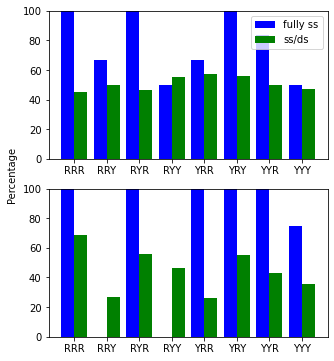

In [100]:
hist={"AAA":[], "AAC":[], "ACA":[], "ACC":[], "CAA":[], "CAC":[], "CCA":[], "CCC":[]}
tick = ["RRR", "RRY", "RYR", "RYY", "YRR", "YRY", "YYR", "YYY"]

for key in res_cluster_1A.keys():
    if (res_cluster_1A[key]["contact_ss"]+res_cluster_1A[key]["mixte_ss"]+res_cluster_1A[key]["nocontact_ss"]) != 0:
        hist[key].append(round((100*(res_cluster_1A[key]["contact_ss"]/(res_cluster_1A[key]["contact_ss"]+res_cluster_1A[key]["mixte_ss"]+res_cluster_1A[key]["nocontact_ss"]))),2))
    else:
        hist[key].append(0)
    if (res_cluster_1A[key]["contact_mixte"]+res_cluster_1A[key]["mixte_mixte"]+res_cluster_1A[key]["nocontact_mixte"]+res_cluster_1A[key]["contact_ds"]+res_cluster_1A[key]["mixte_ds"]+res_cluster_1A[key]["nocontact_ds"]) != 0:
        hist[key].append(round((100*((res_cluster_1A[key]["contact_mixte"]+res_cluster_1A[key]["contact_ds"])/(res_cluster_1A[key]["contact_mixte"]+res_cluster_1A[key]["mixte_mixte"]+res_cluster_1A[key]["nocontact_mixte"]+res_cluster_1A[key]["contact_ds"]+res_cluster_1A[key]["mixte_ds"]+res_cluster_1A[key]["nocontact_ds"]))),2))
    else:
        hist[key].append(0)
        
a = [row[0] for row in list(hist.values())]
b = [row[1] for row in list(hist.values())]

hist_3A={"AAA":[], "AAC":[], "ACA":[], "ACC":[], "CAA":[], "CAC":[], "CCA":[], "CCC":[]}

for key in res_cluster_3A.keys():
    if (res_cluster_3A[key]["contact_ss"]+res_cluster_3A[key]["mixte_ss"]+res_cluster_3A[key]["nocontact_ss"]) != 0:
        hist_3A[key].append(round((100*(res_cluster_3A[key]["contact_ss"]/(res_cluster_3A[key]["contact_ss"]+res_cluster_3A[key]["mixte_ss"]+res_cluster_3A[key]["nocontact_ss"]))),2))
    else:
        hist_3A[key].append(0)
    if (res_cluster_3A[key]["contact_mixte"]+res_cluster_3A[key]["mixte_mixte"]+res_cluster_3A[key]["nocontact_mixte"]+res_cluster_3A[key]["contact_ds"]+res_cluster_3A[key]["mixte_ds"]+res_cluster_3A[key]["nocontact_ds"]) != 0:
        hist_3A[key].append(round((100*((res_cluster_3A[key]["contact_mixte"]+res_cluster_3A[key]["contact_ds"])/(res_cluster_3A[key]["contact_mixte"]+res_cluster_3A[key]["mixte_mixte"]+res_cluster_3A[key]["nocontact_mixte"]+res_cluster_3A[key]["contact_ds"]+res_cluster_3A[key]["mixte_ds"]+res_cluster_3A[key]["nocontact_ds"]))),2))
    else:
        hist_3A[key].append(0)
        
a_3A = [row[0] for row in list(hist_3A.values())]
b_3A = [row[1] for row in list(hist_3A.values())]

fig4 = plt.figure(figsize=(5, 6))
gs = gridspec.GridSpec(2, 1)

x1= [i-0.2 for i in range(8)]
x2= [i+0.2 for i in range(8)]

ax1 = plt.subplot(gs[0, 0])
ax1.bar(x1, a, width=0.4, color='b', align='center', label="fully ss")
ax1.bar(x2, b, width=0.4, color='g', align='center', label="ss/ds")
ax1.xaxis.set_ticks(range(8))
ax1.xaxis.set_ticklabels(tick, color="black")
ax1.set_ylim(0,100)

ax2 = plt.subplot(gs[1, 0])
ax2.bar(x1, a_3A, width=0.4, color='b', align='center', label="fully ss")
ax2.bar(x2, b_3A, width=0.4, color='g', align='center', label="ss/ds")
ax2.xaxis.set_ticks(range(8))
ax2.xaxis.set_ticklabels(tick, color="black")
ax2.set_ylim(0,100)

fig4.text(0.01, 0.5, 'Percentage', va='center', rotation='vertical')
ax1.legend(loc="upper right")

plt.savefig("fig9.eps", facecolor="w", dpi=600, format='eps')
plt.show()


In [83]:
for motif in res_cluster_1A.keys():
    ss = res_cluster_1A[motif]["contact_ss"]+res_cluster_1A[motif]["nocontact_ss"]+res_cluster_1A[motif]["mixte_ss"]
    mixte = res_cluster_1A[motif]["contact_ds"]+res_cluster_1A[motif]["nocontact_ds"]+res_cluster_1A[motif]["mixte_ds"]+res_cluster_1A[motif]["contact_mixte"]+res_cluster_1A[motif]["nocontact_mixte"]+res_cluster_1A[motif]["mixte_mixte"]
    successes = np.array([res_cluster_1A[motif]["contact_ss"], res_cluster_1A[motif]["contact_ds"] + res_cluster_1A[motif]["contact_mixte"]])
    samples = np.array([ss, mixte])

    stat, p_value = proportions_ztest(count=successes, nobs=samples, alternative='two-sided')

    print(motif, stat, p_value)

AAA 2.2793082678668197 0.022648746901423676
AAC 0.5536517085902933 0.5798172306404992
ACA 2.0701966780270626 0.03843393023678171
ACC -0.20836834439707666 0.8349413713644924
CAA 0.305788314862575 0.759765825978067
CAC 0.8818542957898381 0.37785560541883
CCA 1.4737522523672244 0.1405483084370245
CCC 0.10597144202125483 0.9156050105391481


The next cell is showing the values in the Figure.5 of the paper.

In [84]:
for motif in res_cluster_1A.keys():
    print("{}        ss  mixte  ds  ".format(motif))
    print("nocontact ",res_cluster_1A[motif]['nocontact_ss'],"    ", res_cluster_1A[motif]['nocontact_mixte'], "  ",res_cluster_1A[motif]['nocontact_ds'])
    print("mixte     ", res_cluster_1A[motif]['mixte_ss'], "   ", res_cluster_1A[motif]['mixte_mixte'], "  ", res_cluster_1A[motif]['mixte_ds'])
    print("contact   ",res_cluster_1A[motif]['contact_ss'], "    ",res_cluster_1A[motif]['contact_mixte'], "  ", res_cluster_1A[motif]['contact_ds'])

AAA        ss  mixte  ds  
nocontact  0      0    0
mixte      0     17    0
contact    5      7    7
AAC        ss  mixte  ds  
nocontact  1      0    0
mixte      0     17    0
contact    2      13    4
ACA        ss  mixte  ds  
nocontact  0      1    0
mixte      0     29    0
contact    4      14    12
ACC        ss  mixte  ds  
nocontact  2      0    0
mixte      0     12    0
contact    2      9    6
CAA        ss  mixte  ds  
nocontact  1      0    0
mixte      0     14    0
contact    2      11    8
CAC        ss  mixte  ds  
nocontact  0      0    0
mixte      0     26    0
contact    1      14    19
CCA        ss  mixte  ds  
nocontact  1      0    0
mixte      0     12    0
contact    5      8    4
CCC        ss  mixte  ds  
nocontact  2      0    0
mixte      0     9    0
contact    2      5    3


## Size of interfaces in protein-bound RNA hairpin loops

In this part we are interested into hairpins, they are a particular secondary structure of the RNA. We will create a benchmark of hairpins here and then have a look at the number of nucleotides in contact with the protein.

In [85]:
%%bash

cd $PROTNAFF/data_dna
python $PROTNAFF/create_benchmark/filters/query_hairpin.py 3dna/ structures.json test_hairpin_dna.list --ss 3 --ds 3 --contact 0

1H38
1HYS
1MSW
1QLN
1S76
1S77
1ZBI
1ZBL
2DLC
2G8FA
2G8FB
2G8HA
2G8HB
2G8IA
2G8IB
2G8KA
2G8KB
2G8U
2G8VA
2G8VB
2G8W
2HVR
2HVS
2NVQ
2O5I
2O5J
2PPB
2Q2T
2Q2U
2QK9
2QKB
2R7Y
3AGV
3BSUA
3BSUB
3DD2
3E2E
3F73
3HK2
3HO1
3KJO
3KYL
3O3F
3O3G
3O3H
3RZO
3S14
3TWH
3ULD
3UQ0
3UQ2
3X1L
4BOC
4BWM
4DQSA
4DQSB
4FO6
4FXD
4G7O
4GG4
4H8K
4KHS
4KHU
4KHW
4KHY
4KI4
4KI6
4NDFA
4NDFB
4NDG
4NDIA
4NDIB
4O9M
4OO8
4PQU
4PUO
4PUQA
4PUQB
4PWD
4PY5
4Q5S
4Q5V
4QCL
4UN3
4UN4
4UN5
4WB3
5AWH
5AXWA
5AXWB
5B2O
5B2P
5B2Q
5B2R
5B2S
5B2T
5B43
5BS3
5CR2
5CZZA
5CZZB
5DO4
5EV1
5EV2
5EV3
5EV4
5F0Q
5F0S
5FQ5
5FW1
5FW2
5FW3
5H9F
5JS2
5KW1
5MGA
5N9G
5NFV
5SWMA
5SWMB
5SWMC
5TWSA
5TWSB
5U30
5U31
5US2
5USA
5USB
5USE
5USG
5USN
5USO
5VAJ
5VOE
5VOF
5VZ8A
5VZ8B
5VZBA
5VZBB
5VZEA
5VZEB
5VZHA
5VZHB
5W7N
5W7O
5WJR
5WTI
5X2G
5X2H
5XH6
5XH7
5XN0
5XN2
5XOG
5XOW
5XPA
5XPG
5XUS
5XUT
5XUU
5XUZ
5ZKJ
5ZRF
5ZX2
6AEG
6AI6
6B44
6BHJ
6BM4
6BSG
6BSH
6BSJ
6CVO
6CVP
6CVQA
6CVQB
6CVR
6CVT
6D8A
6D8F
6D8P
6D92
6D95
6D9K
6D9L
6DMN
6DMV
6DO8
6DO9
6DOA
6DOB
6DOC
6

In [86]:
with open("{}/test_hairpin_dna.list".format(folder)) as ff:
    lines = ff.readlines()

In [87]:
hairpins = []
for line in lines:
    try:
        tmp = line.rstrip().split()
        tmp[2] = int(tmp[2][2:-2])
        tmp[3] = int(tmp[3][1:-2])
        if len(tmp[-1]) == tmp[3] - tmp[2] + 1:
            hairpins.append(tmp)
    except:
        pass
print(len(hairpins))

34


In [88]:
results_hairpins = {}
for hairpin in hairpins:
    try:
        if hairpin[0] not in results_hairpins.keys():
            results_hairpins[hairpin[0]] = {}
        if structures[hairpin[0]]["method"] == "solide nmr" or structures[hairpin[0]]["method"] == "solution nmr" or structures[hairpin[0]]["resolution"] < 3:
            jj = len(results_hairpins[hairpin[0]].keys())
            results_hairpins[hairpin[0]][jj] = {"contact_ss":0, "contact_ds":0, "nocontact":0}
            chain = "chain_" + hairpin[1]
            interface = set()
            for nucl in structures[hairpin[0]]["interface_protein"]["model_1"][chain].keys():
                tmp = nucl.split('_')[1]
                interface.add(structures[hairpin[0]]["mapping"][chain][tmp])
            for ii in range(hairpin[2], hairpin[3]+1):
                if str(ii) in interface:
                    if int(ii) - hairpin[2] < 3 or hairpin[3] - int(ii) < 3:
                        results_hairpins[hairpin[0]][jj]["contact_ds"] += 1
                    else:
                        results_hairpins[hairpin[0]][jj]["contact_ss"] += 1
                else:
                    results_hairpins[hairpin[0]][jj]["nocontact"] += 1
    except:
        pass

In [89]:
for key in results_hairpins.keys():
    pop_one = []
    for chain in results_hairpins[key].keys():
        if results_hairpins[key][chain]['contact_ss'] == 0:
            pop_one.append(chain)
    for ii in pop_one:
        results_hairpins[key].pop(ii)

In [90]:
length_contact = {}
for hh in results_hairpins.keys():
    for kk in results_hairpins[hh].keys():
        l = results_hairpins[hh][kk]['contact_ss'] + results_hairpins[hh][kk]["nocontact"] + results_hairpins[hh][kk]["contact_ds"] - 6
        if l in length_contact.keys():
            if results_hairpins[hh][kk]['contact_ss'] in length_contact[l].keys():
                length_contact[l][results_hairpins[hh][kk]['contact_ss']] += 1
            else:
                length_contact[l][results_hairpins[hh][kk]['contact_ss']] = 1
        else:
            length_contact[l]= {}
            length_contact[l][results_hairpins[hh][kk]['contact_ss']] = 1
print(length_contact)

{6: {1: 2, 3: 1}, 3: {3: 5}, 16: {11: 2}, 9: {6: 1, 9: 1, 2: 1}, 5: {4: 1, 2: 2}, 8: {2: 1, 7: 1}, 4: {2: 1, 3: 1, 4: 1}, 10: {9: 1, 10: 1}, 7: {6: 1, 3: 1, 5: 1}}


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


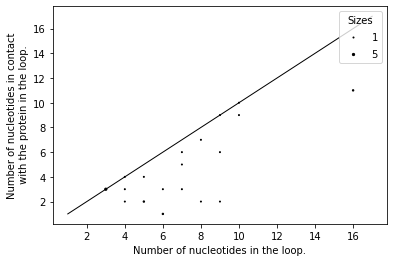

In [99]:
import numpy as np
x = []
y = []
points_size = []
for ii in length_contact.keys():
    for jj in range(len(list(length_contact[ii].keys()))):
        x.append(ii)
    for kk in length_contact[ii].keys():
        y.append(kk)
        points_size.append(length_contact[ii][kk])

#z = [pow(1.25,x) for x in z]
#print(z)
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = plt.scatter(x,y,c="black", s=points_size)
plt.plot([1,17],[1,17],'k-',lw=1)
plt.xlabel("Number of nucleotides in the loop.", color="black")
plt.ylabel("Number of nucleotides in contact\n with the protein in the loop.", color="black")

handles, labels = scatter.legend_elements(prop="sizes", num=[min(points_size), max(points_size)], alpha=1)
legend2 = ax.legend(handles, labels, loc="upper right", title="Sizes")

plt.savefig("fig10.eps", facecolor="w", dpi=600, format='eps')

In [92]:
for hairpin in hairpins:
    if len(hairpin[-1]) > 15:
        print(hairpin)

['6RTIA', 'X', 13, 34, 'GACCTGACTTCTATACTAAGTC']
['6RTIB', 'X', 13, 34, 'GACCTGACTTCTATACTAAGTC']
['6ZVH', '2', 439, 454, 'AGCCTGAGAAACGGCT']
['6ZVH', '2', 1612, 1627, 'GGATTGCAATTATTCC']


## Supplementary

Those are the supplementary data and figures of the paper.

The first filter selects all the single-stranded
nucleotides in contact with a protein (Suppl. XXX). To that end, two sets are constructed: 
one containing all the single-stranded nucleotides and one
containing all the nucleotides at the protein interface. Then the intersection
of these two sets is kept. As a result, 18,506 nucleotides are obtained from
1958 PDB chains (10 per PDB structure on average).

In [93]:
ss_set = set(["L", "T", "S", "J", "B", "I"])
struct = 0
nb_nucl = 0
for pdb_id in structures.keys():
    for chain in structures[pdb_id]["nachains"]:
        nuclfrag = set()
        chain_id = "chain_" + chain
        ss = structures[pdb_id]['ss'][chain_id]

        interf_prot = structures[pdb_id]["interface_protein"]["model_1"][chain_id]
        # print(interf_prot)
        for element in interf_prot:
            element = element.split("_")[1]

        # List of interface nucleotide resid
        nucl_interf = list(interf_prot.keys())
        nucl_interf = [element.split("_")[1] for element in nucl_interf]
        # List of single-stranded nucleotides resid
        nucl_ss = [n.split("_")[1] for n in ss if ss[n][0] in ss_set]
        # List of single-stranded interface nucleotide resid
        nucl_interf_ss = [int(n) for n in nucl_interf if n in nucl_ss]
        nucl_interf_ss.sort()
        if len(nucl_interf_ss) > 0:
            struct += 1
            nb_nucl += len(nucl_interf_ss)
        #print(pdb_id, chain_id, nucl_interf_ss)
print("Number of RNA chains: {} \nNumber of nucleotides: {}".format(struct, nb_nucl))

Number of RNA chains: 298 
Number of nucleotides: 1625


The second filter can be found in `./create_benchmark/filters/query_hairpin.py`, it is more complicated than the previous one. If you need explanation you can send us a mail.

The next 3 cells are here to calculate the percentage of trinucleotides in contact with proteins according to the sequence.

In [94]:
letter = ["A", "T", "G", "C"]
resultats_all = {}
for ii in letter:
    for jj in letter:
        for kk in letter:
            resultats_all[ii+jj+kk] = {}

for key in fragments.keys():
    for key2 in fragments[key].keys():
        model = "model_" + str(fragments[key][key2]["model"])
        chain = "chain_" + str(fragments[key][key2]["chain"])
        seq = fragments[key][key2]['seq']
        contact = False
        interface = set()
        nucl2=[]
        mapping_rev={}
        for nn in structures[fragments[key][key2]['structure']]["mapping"][chain].keys():
            mapping_rev[structures[fragments[key][key2]['structure']]["mapping"][chain][nn]] = nn
        for nucl in structures[fragments[key][key2]['structure']]["interface_protein"]["model_1"][chain].keys():
            tmp = nucl.split('_')[1]
            interface.add(structures[fragments[key][key2]['structure']]["mapping"][chain][tmp])
        ss=True
        ds=0
        for nucl in fragments[key][key2]['resid']:
            if nucl in interface:
                contact = True
            nucl2.append(mapping_rev[nucl])
        for nucl in nucl2:
            if structures[fragments[key][key2]['structure']]["ss"][chain]["res_"+nucl][0]=="D":
                ss=False
                ds+=1
        if fragments[key][key2]['clust1.0'] not in resultats_all[seq].keys():
            resultats_all[seq][fragments[key][key2]['clust1.0']] = {"contact_ss":0, "contact_ds":0, "contact_mixte":0, "nocontact_ss":0, "nocontact_ds":0, "nocontact_mixte":0}
        if contact:
            if ss:
                resultats_all[seq][fragments[key][key2]['clust1.0']]["contact_ss"] += 1
            elif ds == 3:
                resultats_all[seq][fragments[key][key2]['clust1.0']]["contact_ds"] += 1
            else:
                resultats_all[seq][fragments[key][key2]['clust1.0']]["contact_mixte"] += 1
        else:
            if ss:
                resultats_all[seq][fragments[key][key2]['clust1.0']]["nocontact_ss"] += 1
            elif ds == 3:
                resultats_all[seq][fragments[key][key2]['clust1.0']]["nocontact_ds"] += 1
            else:
                resultats_all[seq][fragments[key][key2]['clust1.0']]["nocontact_mixte"] += 1
        

In [95]:
letter = ["A", "T", "G", "C"]
resultats_all_bis = {}
for ii in letter:
    for jj in letter:
        for kk in letter:
            resultats_all_bis[ii+jj+kk] = {}
            
for key in resultats_all.keys():
    con_ss = 0
    sum_con_ss = 0
    con_ds = 0
    sum_con_ds = 0
    con_mixte = 0
    sum_con_mixte = 0
    nocon_ss = 0
    sum_nocon_ss = 0
    nocon_ds = 0
    sum_nocon_ds = 0
    nocon_mixte = 0
    sum_nocon_mixte = 0
    mixte_ss = 0
    sum_mixte_ss = 0
    mixte_ds = 0
    sum_mixte_ds = 0
    mixte_mixte = 0
    sum_mixte_mixte=0
    j = 0
    print(key)
    for clust in resultats_all[key].keys():
        j += 1
        if resultats_all[key][clust]["contact_ss"] + resultats_all[key][clust]["contact_ds"] + resultats_all[key][clust]["contact_mixte"] + resultats_all[key][clust]["nocontact_ss"] + resultats_all[key][clust]["nocontact_ds"] + resultats_all[key][clust]["nocontact_mixte"] > 2:
            if resultats_all[key][clust]["nocontact_mixte"] == 0 and resultats_all[key][clust]["nocontact_ds"] == 0 and resultats_all[key][clust]["nocontact_ss"] == 0:
                #print(clust, results[key][clust])
                if resultats_all[key][clust]["contact_mixte"] > 0:
                    con_mixte += 1
                    sum_con_mixte += resultats_all[key][clust]["contact_ss"] + resultats_all[key][clust]["contact_ds"] + resultats_all[key][clust]["contact_mixte"]
                else:
                    if resultats_all[key][clust]["contact_ds"] == 0:
                        con_ss += 1
                        sum_con_ss += resultats_all[key][clust]["contact_ss"]
                    else:
                        con_ds += 1
                        sum_con_ds += resultats_all[key][clust]["contact_ds"]
            elif resultats_all[key][clust]["contact_ss"] == 0 and resultats_all[key][clust]["contact_ds"] == 0 and resultats_all[key][clust]["contact_mixte"] == 0:
                if resultats_all[key][clust]["nocontact_mixte"] > 0:
                    nocon_mixte += 1
                    sum_nocon_mixte += resultats_all[key][clust]["nocontact_ss"] + resultats_all[key][clust]["nocontact_ds"] + resultats_all[key][clust]["nocontact_mixte"]
                else:
                    if resultats_all[key][clust]["nocontact_ss"] == 0:
                        nocon_ds += 1
                        sum_nocon_ds += resultats_all[key][clust]["nocontact_ds"]
                    else:
                        nocon_ss += 1
                        sum_nocon_ss += resultats_all[key][clust]["nocontact_ss"]

            else:
                if resultats_all[key][clust]["nocontact_mixte"] > 0 or resultats_all[key][clust]["contact_mixte"] > 0 or (resultats_all[key][clust]["nocontact_ss"] != 0 and resultats_all[key][clust]["nocontact_ds"] !=0) or (resultats_all[key][clust]["contact_ss"] != 0 or resultats_all[key][clust]["contact_ds"] !=0):
                    mixte_mixte += 1
                    sum_mixte_mixte += resultats_all[key][clust]["nocontact_ss"] + resultats_all[key][clust]["nocontact_ds"] + resultats_all[key][clust]["nocontact_mixte"] + resultats_all[key][clust]["contact_ss"] + resultats_all[key][clust]["contact_ds"] + resultats_all[key][clust]["contact_mixte"]
                else:
                    if resultats_all[key][clust]["contact_ss"] == 0 and resultats_all[key][clust]["nocontact_ss"] == 0:
                        mixte_ds += 1
                        sum_mixte_ds += resultats_all[key][clust]["nocontact_ds"] + resultats_all[key][clust]["contact_ds"]
                    else:
                        mixte_ss += 1
                        sum_mixte_ss += resultats_all[key][clust]["contact_ss"] + resultats_all[key][clust]["nocontact_ss"]             

    resultats_all_bis[key] = {"contact_ss":con_ss, "contact_ds":con_ds, "contact_mixte":con_mixte, "nocontact_ss":nocon_ss, "nocontact_ds":nocon_ds, "nocontact_mixte":nocon_mixte, "mixte_ss":mixte_ss, "mixte_ds":mixte_ds, "mixte_mixte":mixte_mixte, \
                   "sum_contact_ss":sum_con_ss, "sum_contact_ds":sum_con_ds, "sum_contact_mixte":sum_con_mixte, \
                   "sum_nocontact_ss":sum_nocon_ss, "sum_nocontact_ds":sum_nocon_ds, "sum_nocontact_mixte":sum_nocon_mixte,\
                   "sum_mixte_ss":sum_mixte_ss, "sum_mixte_ds":sum_mixte_ds, "sum_mixte_mixte":sum_mixte_mixte}
    

AAA
AAT
AAG
AAC
ATA
ATT
ATG
ATC
AGA
AGT
AGG
AGC
ACA
ACT
ACG
ACC
TAA
TAT
TAG
TAC
TTA
TTT
TTG
TTC
TGA
TGT
TGG
TGC
TCA
TCT
TCG
TCC
GAA
GAT
GAG
GAC
GTA
GTT
GTG
GTC
GGA
GGT
GGG
GGC
GCA
GCT
GCG
GCC
CAA
CAT
CAG
CAC
CTA
CTT
CTG
CTC
CGA
CGT
CGG
CGC
CCA
CCT
CCG
CCC


In [96]:
for motif in resultats_all_bis.keys():
    print(motif, (resultats_all_bis[motif]["sum_contact_ss"]+resultats_all_bis[motif]["sum_contact_ds"]+resultats_all_bis[motif]["sum_contact_mixte"])/(resultats_all_bis[motif]["sum_contact_ss"]+resultats_all_bis[motif]["sum_contact_ds"]+resultats_all_bis[motif]["sum_contact_mixte"]+resultats_all_bis[motif]["sum_mixte_ss"]+resultats_all_bis[motif]["sum_mixte_ds"]+resultats_all_bis[motif]["sum_mixte_mixte"]+resultats_all_bis[motif]["sum_nocontact_ss"]+resultats_all_bis[motif]["sum_nocontact_ds"]+resultats_all_bis[motif]["sum_nocontact_mixte"]))

AAA 0.639344262295082
AAT 0.15
AAG 0.05714285714285714
AAC 0.4126984126984127
ATA 0.7105263157894737
ATT 0.09137055837563451
ATG 0.632
ATC 0.2336448598130841
AGA 0.4444444444444444
AGT 0.3490566037735849
AGG 0.034482758620689655
AGC 0.36633663366336633
ACA 0.8333333333333334
ACT 0.07462686567164178
ACG 0.8
ACC 0.1893939393939394
TAA 0.44545454545454544
TAT 0.39325842696629215
TAG 0.15714285714285714
TAC 0.6129032258064516
TTA 0.18867924528301888
TTT 0.3333333333333333
TTG 0.17346938775510204
TTC 0.03896103896103896
TGA 0.17557251908396945
TGT 0.7523809523809524
TGG 0.43283582089552236
TGC 0.0
TCA 0.13333333333333333
TCT 0.0
TCG 0.22627737226277372
TCC 0.028985507246376812
GAA 0.0297029702970297
GAT 0.3219178082191781
GAG 0.4175824175824176
GAC 0.10476190476190476
GTA 0.6515151515151515
GTT 0.06741573033707865
GTG 0.22807017543859648
GTC 0.11627906976744186
GGA 0.033707865168539325
GGT 0.125
GGG 0.109375
GGC 0.0963855421686747
GCA 0.8690476190476191
GCT 0.08450704225352113
GCG 0.4272727

The next two cells are creating the LaTeX tables found in supplementary in the paper.
They are presenting the number of clusters depending of their characteristics (ss/ds, contact/no contact). The numbers in brackets are the number of conformations.

In [97]:
for key in res_cluster_1A.keys():
    sum_tt = res_cluster_1A[key]['sum_contact_ss']+res_cluster_1A[key]['sum_contact_ds']+res_cluster_1A[key]['sum_contact_mixte']+res_cluster_1A[key]['sum_nocontact_ss']+res_cluster_1A[key]['sum_nocontact_ds']+res_cluster_1A[key]['sum_nocontact_mixte']+res_cluster_1A[key]['sum_mixte_ss']+res_cluster_1A[key]['sum_mixte_ds']+res_cluster_1A[key]['sum_mixte_mixte']
    texte = []
    texte.append("\hline")
    texte.append("{} & ss & mixed & ds   & total \\\\ \hline".format(key))
    texte.append("contact   & {}({}) & {}({})   & {}({}) & {}({})  \\\\ \hline".format(res_cluster_1A[key]['contact_ss'], res_cluster_1A[key]['sum_contact_ss'], res_cluster_1A[key]['contact_mixte'], res_cluster_1A[key]['sum_contact_mixte'], res_cluster_1A[key]['contact_ds'], res_cluster_1A[key]['sum_contact_ds'], str(res_cluster_1A[key]['contact_ss']+res_cluster_1A[key]['contact_mixte']+res_cluster_1A[key]['contact_ds']), str(res_cluster_1A[key]['sum_contact_ss']+res_cluster_1A[key]['sum_contact_mixte']+res_cluster_1A[key]['sum_contact_ds'])))
    texte.append("mixed   & {}({}) & {}({})   & {}({}) & {}({})  \\\\ \hline".format(res_cluster_1A[key]['mixte_ss'], res_cluster_1A[key]['sum_mixte_ss'], res_cluster_1A[key]['mixte_mixte'], res_cluster_1A[key]['sum_mixte_mixte'],  res_cluster_1A[key]['mixte_ds'], res_cluster_1A[key]['sum_mixte_ds'], str(res_cluster_1A[key]['mixte_ss']+res_cluster_1A[key]['mixte_mixte']+res_cluster_1A[key]['mixte_ds']), str(res_cluster_1A[key]['sum_mixte_ss']+res_cluster_1A[key]['sum_mixte_mixte']+res_cluster_1A[key]['sum_mixte_ds'])))
    texte.append("nocontact &  {}({}) & {}({})   & {}({}) & {}({})  \\\\ \hline".format(res_cluster_1A[key]['nocontact_ss'], res_cluster_1A[key]['sum_nocontact_ss'], res_cluster_1A[key]['nocontact_mixte'], res_cluster_1A[key]['sum_nocontact_mixte'], res_cluster_1A[key]['nocontact_ds'], res_cluster_1A[key]['sum_nocontact_ds'], str(res_cluster_1A[key]['nocontact_ss']+res_cluster_1A[key]['nocontact_mixte']+res_cluster_1A[key]['nocontact_ds']), str(res_cluster_1A[key]['sum_nocontact_ss']+res_cluster_1A[key]['sum_nocontact_mixte']+res_cluster_1A[key]['sum_nocontact_ds'])))
    texte.append("total   & {}({}) & {}({})   & {}({}) & {}({})  \\\\ \hline".format(res_cluster_1A[key]['contact_ss']+res_cluster_1A[key]['mixte_ss']+res_cluster_1A[key]['nocontact_ss'], str(res_cluster_1A[key]['sum_contact_ss']+res_cluster_1A[key]['sum_mixte_ss']+res_cluster_1A[key]['sum_nocontact_ss']), res_cluster_1A[key]['contact_mixte']+res_cluster_1A[key]['mixte_mixte']+res_cluster_1A[key]['nocontact_mixte'], res_cluster_1A[key]['sum_contact_mixte']+res_cluster_1A[key]['sum_mixte_mixte']+res_cluster_1A[key]['sum_nocontact_mixte'], res_cluster_1A[key]['contact_ds']+res_cluster_1A[key]['mixte_ds']+res_cluster_1A[key]['nocontact_ds'], res_cluster_1A[key]['sum_contact_ds']+res_cluster_1A[key]['sum_mixte_ds']+res_cluster_1A[key]['sum_nocontact_ds'], str(res_cluster_1A[key]['contact_ss']+res_cluster_1A[key]['contact_mixte']+res_cluster_1A[key]['contact_ds']+res_cluster_1A[key]['mixte_ss']+res_cluster_1A[key]['mixte_mixte']+res_cluster_1A[key]['mixte_ds']+res_cluster_1A[key]['nocontact_ss']+res_cluster_1A[key]['nocontact_mixte']+res_cluster_1A[key]['nocontact_ds']), sum_tt))
    for ii in texte:
        print(ii)

\hline
AAA & ss & mixed & ds   & total \\ \hline
contact   & 5(20) & 7(48)   & 7(27) & 19(95)  \\ \hline
mixed   & 0(0) & 17(722)   & 0(0) & 17(722)  \\ \hline
nocontact &  0(0) & 0(0)   & 0(0) & 0(0)  \\ \hline
total   & 5(20) & 24(770)   & 7(27) & 36(817)  \\ \hline
\hline
AAC & ss & mixed & ds   & total \\ \hline
contact   & 2(6) & 13(118)   & 4(15) & 19(139)  \\ \hline
mixed   & 0(0) & 17(825)   & 0(0) & 17(825)  \\ \hline
nocontact &  1(19) & 0(0)   & 0(0) & 1(19)  \\ \hline
total   & 3(25) & 30(943)   & 4(15) & 37(983)  \\ \hline
\hline
ACA & ss & mixed & ds   & total \\ \hline
contact   & 4(24) & 14(98)   & 12(81) & 30(203)  \\ \hline
mixed   & 0(0) & 29(564)   & 0(0) & 29(564)  \\ \hline
nocontact &  0(0) & 1(6)   & 0(0) & 1(6)  \\ \hline
total   & 4(24) & 44(668)   & 12(81) & 60(773)  \\ \hline
\hline
ACC & ss & mixed & ds   & total \\ \hline
contact   & 2(7) & 9(49)   & 6(38) & 17(94)  \\ \hline
mixed   & 0(0) & 12(930)   & 0(0) & 12(930)  \\ \hline
nocontact &  2(21) & 0(0) 

In [98]:
for key in res_cluster_1A.keys():
    sum_tt = res_cluster_1A[key]['sum_contact_ss']+res_cluster_1A[key]['sum_contact_ds']+res_cluster_1A[key]['sum_contact_mixte']+res_cluster_1A[key]['sum_nocontact_ss']+res_cluster_1A[key]['sum_nocontact_ds']+res_cluster_1A[key]['sum_nocontact_mixte']+res_cluster_1A[key]['sum_mixte_ss']+res_cluster_1A[key]['sum_mixte_ds']+res_cluster_1A[key]['sum_mixte_mixte']
    sum_tt_3A = res_cluster_3A[key]['sum_contact_ss']+res_cluster_3A[key]['sum_contact_ds']+res_cluster_3A[key]['sum_contact_mixte']+res_cluster_3A[key]['sum_nocontact_ss']+res_cluster_3A[key]['sum_nocontact_ds']+res_cluster_3A[key]['sum_nocontact_mixte']+res_cluster_3A[key]['sum_mixte_ss']+res_cluster_3A[key]['sum_mixte_ds']+res_cluster_3A[key]['sum_mixte_mixte']
    texte = []
    texte.append("\hline")
    texte.append("{} 1A & ss & mixed & ds   & total & {} 3A & ss & mixed & ds   & total \\\\ \hline".format(key, key))
    texte.append("contact   & {}({}) & {}({})   & {}({}) & {}({}) & contact   & {}({}) & {}({})   & {}({}) & {}({}) \\\\ \hline".format(res_cluster_1A[key]['contact_ss'], res_cluster_1A[key]['sum_contact_ss'], res_cluster_1A[key]['contact_mixte'], res_cluster_1A[key]['sum_contact_mixte'], res_cluster_1A[key]['contact_ds'], res_cluster_1A[key]['sum_contact_ds'], str(res_cluster_1A[key]['contact_ss']+res_cluster_1A[key]['contact_mixte']+res_cluster_1A[key]['contact_ds']), str(res_cluster_1A[key]['sum_contact_ss']+res_cluster_1A[key]['sum_contact_mixte']+res_cluster_1A[key]['sum_contact_ds']), res_cluster_3A[key]['contact_ss'], res_cluster_3A[key]['sum_contact_ss'], res_cluster_3A[key]['contact_mixte'], res_cluster_3A[key]['sum_contact_mixte'], res_cluster_3A[key]['contact_ds'], res_cluster_3A[key]['sum_contact_ds'], str(res_cluster_3A[key]['contact_ss']+res_cluster_3A[key]['contact_mixte']+res_cluster_3A[key]['contact_ds']), str(res_cluster_3A[key]['sum_contact_ss']+res_cluster_3A[key]['sum_contact_mixte']+res_cluster_3A[key]['sum_contact_ds'])))
    texte.append("mixed   & {}({}) & {}({})   & {}({}) & {}({}) & mixed   & {}({}) & {}({})   & {}({}) & {}({}) \\\\ \hline".format(res_cluster_1A[key]['mixte_ss'], res_cluster_1A[key]['sum_mixte_ss'], res_cluster_1A[key]['mixte_mixte'], res_cluster_1A[key]['sum_mixte_mixte'],  res_cluster_1A[key]['mixte_ds'], res_cluster_1A[key]['sum_mixte_ds'], str(res_cluster_1A[key]['mixte_ss']+res_cluster_1A[key]['mixte_mixte']+res_cluster_1A[key]['mixte_ds']), str(res_cluster_1A[key]['sum_mixte_ss']+res_cluster_1A[key]['sum_mixte_mixte']+res_cluster_1A[key]['sum_mixte_ds']), res_cluster_3A[key]['mixte_ss'], res_cluster_3A[key]['sum_mixte_ss'], res_cluster_3A[key]['mixte_mixte'], res_cluster_3A[key]['sum_mixte_mixte'],  res_cluster_3A[key]['mixte_ds'], res_cluster_3A[key]['sum_mixte_ds'], str(res_cluster_3A[key]['mixte_ss']+res_cluster_3A[key]['mixte_mixte']+res_cluster_3A[key]['mixte_ds']), str(res_cluster_3A[key]['sum_mixte_ss']+res_cluster_3A[key]['sum_mixte_mixte']+res_cluster_3A[key]['sum_mixte_ds'])))
    texte.append("nocontact &  {}({}) & {}({})   & {}({}) & {}({}) & nocontact &  {}({}) & {}({})   & {}({}) & {}({}) \\\\ \hline".format(res_cluster_1A[key]['nocontact_ss'], res_cluster_1A[key]['sum_nocontact_ss'], res_cluster_1A[key]['nocontact_mixte'], res_cluster_1A[key]['sum_nocontact_mixte'], res_cluster_1A[key]['nocontact_ds'], res_cluster_1A[key]['sum_nocontact_ds'], str(res_cluster_1A[key]['nocontact_ss']+res_cluster_1A[key]['nocontact_mixte']+res_cluster_1A[key]['nocontact_ds']), str(res_cluster_1A[key]['sum_nocontact_ss']+res_cluster_1A[key]['sum_nocontact_mixte']+res_cluster_1A[key]['sum_nocontact_ds']),res_cluster_3A[key]['nocontact_ss'], res_cluster_3A[key]['sum_nocontact_ss'], res_cluster_3A[key]['nocontact_mixte'], res_cluster_3A[key]['sum_nocontact_mixte'], res_cluster_3A[key]['nocontact_ds'], res_cluster_3A[key]['sum_nocontact_ds'], str(res_cluster_3A[key]['nocontact_ss']+res_cluster_3A[key]['nocontact_mixte']+res_cluster_3A[key]['nocontact_ds']), str(res_cluster_3A[key]['sum_nocontact_ss']+res_cluster_3A[key]['sum_nocontact_mixte']+res_cluster_3A[key]['sum_nocontact_ds'])))
    texte.append("total   & {}({}) & {}({})   & {}({}) & {}({}) & total   & {}({}) & {}({})   & {}({}) & {}({})  \\\\ \hline".format(res_cluster_1A[key]['contact_ss']+res_cluster_1A[key]['mixte_ss']+res_cluster_1A[key]['nocontact_ss'], str(res_cluster_1A[key]['sum_contact_ss']+res_cluster_1A[key]['sum_mixte_ss']+res_cluster_1A[key]['sum_nocontact_ss']), res_cluster_1A[key]['contact_mixte']+res_cluster_1A[key]['mixte_mixte']+res_cluster_1A[key]['nocontact_mixte'], res_cluster_1A[key]['sum_contact_mixte']+res_cluster_1A[key]['sum_mixte_mixte']+res_cluster_1A[key]['sum_nocontact_mixte'], res_cluster_1A[key]['contact_ds']+res_cluster_1A[key]['mixte_ds']+res_cluster_1A[key]['nocontact_ds'], res_cluster_1A[key]['sum_contact_ds']+res_cluster_1A[key]['sum_mixte_ds']+res_cluster_1A[key]['sum_nocontact_ds'], str(res_cluster_1A[key]['contact_ss']+res_cluster_1A[key]['contact_mixte']+res_cluster_1A[key]['contact_ds']+res_cluster_1A[key]['mixte_ss']+res_cluster_1A[key]['mixte_mixte']+res_cluster_1A[key]['mixte_ds']+res_cluster_1A[key]['nocontact_ss']+res_cluster_1A[key]['nocontact_mixte']+res_cluster_1A[key]['nocontact_ds']), sum_tt, res_cluster_3A[key]['contact_ss']+res_cluster_3A[key]['mixte_ss']+res_cluster_3A[key]['nocontact_ss'], str(res_cluster_3A[key]['sum_contact_ss']+res_cluster_3A[key]['sum_mixte_ss']+res_cluster_3A[key]['sum_nocontact_ss']), res_cluster_3A[key]['contact_mixte']+res_cluster_3A[key]['mixte_mixte']+res_cluster_3A[key]['nocontact_mixte'], res_cluster_3A[key]['sum_contact_mixte']+res_cluster_3A[key]['sum_mixte_mixte']+res_cluster_3A[key]['sum_nocontact_mixte'], res_cluster_3A[key]['contact_ds']+res_cluster_3A[key]['mixte_ds']+res_cluster_3A[key]['nocontact_ds'], res_cluster_3A[key]['sum_contact_ds']+res_cluster_3A[key]['sum_mixte_ds']+res_cluster_3A[key]['sum_nocontact_ds'], str(res_cluster_3A[key]['contact_ss']+res_cluster_3A[key]['contact_mixte']+res_cluster_3A[key]['contact_ds']+res_cluster_3A[key]['mixte_ss']+res_cluster_3A[key]['mixte_mixte']+res_cluster_3A[key]['mixte_ds']+res_cluster_3A[key]['nocontact_ss']+res_cluster_3A[key]['nocontact_mixte']+res_cluster_3A[key]['nocontact_ds']), sum_tt_3A))
    for ii in texte:
        print(ii)

\hline
AAA 1A & ss & mixed & ds   & total & AAA 3A & ss & mixed & ds   & total \\ \hline
contact   & 5(20) & 7(48)   & 7(27) & 19(95) & contact   & 1(3) & 13(83)   & 0(0) & 14(86) \\ \hline
mixed   & 0(0) & 17(722)   & 0(0) & 17(722) & mixed   & 0(0) & 6(916)   & 0(0) & 6(916) \\ \hline
nocontact &  0(0) & 0(0)   & 0(0) & 0(0) & nocontact &  0(0) & 0(0)   & 0(0) & 0(0) \\ \hline
total   & 5(20) & 24(770)   & 7(27) & 36(817) & total   & 1(3) & 19(999)   & 0(0) & 20(1002)  \\ \hline
\hline
AAC 1A & ss & mixed & ds   & total & AAC 3A & ss & mixed & ds   & total \\ \hline
contact   & 2(6) & 13(118)   & 4(15) & 19(139) & contact   & 0(0) & 4(29)   & 0(0) & 4(29) \\ \hline
mixed   & 0(0) & 17(825)   & 0(0) & 17(825) & mixed   & 0(0) & 11(1124)   & 0(0) & 11(1124) \\ \hline
nocontact &  1(19) & 0(0)   & 0(0) & 1(19) & nocontact &  1(19) & 0(0)   & 0(0) & 1(19) \\ \hline
total   & 3(25) & 30(943)   & 4(15) & 37(983) & total   & 1(19) & 15(1153)   & 0(0) & 16(1172)  \\ \hline
\hline
ACA 1A & ss